<i><h2 style="font-family:serif;font-size:300%; text-align:center;color:#004d80"> Tarea 3 Machine Learning: Métodos No-Lineales</h2></i>

<table>
    <tr>
        <td><i><h2 style="font-family:serif;font-size:150%; text-align:center;color:#004d80">Ignacio Loayza C. 201273604-8</h2></i>
</td>
    </tr>
</table>

<table>
    <tr>
        <td><i><h2 style="font-family:serif;font-size:150%; text-align:center;color:#004d80">Camilo Perez P. 201273533-2</h2></i>
</td>
    </tr>
</table>


### Observación: Este notebook está pensado para ser leido en formato html, por favor descargar la versión en dicho formato for maximum sexyness.


In [375]:
# encoding: utf-8
%matplotlib inline

# semilla
seed = hash("Ñanculef es mi pastor, nada me ha de faltar")%2^32

# Imports

#Neural Networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

#numerico
import numpy as np
import pandas as pd

#Machine Learning
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.linear_model as lm

# KPCA
from sklearn.decomposition import KernelPCA

#Metricas
from sklearn.metrics import f1_score

#Stats models
import statsmodels.api as sm

#Graficos
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("darkgrid")
import graphviz

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Shallow copy
import copy

#preprocesamiento
from sklearn import preprocessing

#HTML incrustation
from IPython.display import display, HTML

display(HTML("""
<style>
p {
    color: black;
    font-family: Serif;
    font-size: 1.23em;
}
.output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }

</style>

"""))


In [325]:
#Funciones
############### DO CIRCLES #####################
def do_circles(n = 2000, noisy_n = 0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2*np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
                  np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype = np.intp),
                  np.ones(n // 2, dtype = np.intp)])
    X += generator.normal(scale = noisy_n, size = X.shape)
    
    X_train , X_test, y_train,y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
    return X_train, y_train, X_test, y_test

############### VISUALIZE BORDER #####################
def visualize_border(x, y, title = "", model = None):
        fig = plt.figure(figsize=(12,6))
        plt.scatter(x[:,0], x[:,1], s = 50, c=y, cmap=plt.cm.winter)
        h = .02 #step size?
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max()+1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        if model is not None:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, cmap = plt.cm.Paired)
        
        plt.title(title)
        plt.show()
############### PLOT CLASSIFIER #####################
"""
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f,axis = plt.subplots(1,1,sharex='col',sharey='row',figsize=(12,8))
    axis.scatter(X_train[:,0], X_train[:,1], s=30, c=Y_train, zorder = 10, cmap = 'cool')
    axis.scatter(X_test[:,0], X_test[:,1], s = 20, c = Y_test, zorder = 10, cmap= 'Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    
    else:raise ValueError('model type not supported')
    
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap = 'YlGn')
    axis.contour(XX, YY, Z, alpha = 1, colors = ['k','k','k'], linestyles = ['--','-','--'], levels = [-2, 0, 2])
    plt.show()
"""
############### CROSS-VALIDATION ERROR #####################
# usaremos esto nuevamente para la regularizacion, como se utiliza bastante seguido la metodologia de obtener
#crossvalidation y regresion, lo implemente en una sola funcion apra llamarla en solo una linea
def cv_error(x_train, y_train,method , k = 10, **kargs):
    Xm = copy.copy(x_train.as_matrix())
    ym = copy.copy(y_train.as_matrix())
    kf = KFold(n_splits = k)

    
    #Decision tree classif
    if(method == 'TreeClassifier'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                tree_clf = DecisionTreeClassifier(max_depth=kargs['max_depth'], criterion = 'entropy') 
            else:
                tree_clf = DecisionTreeClassifier(criterion = 'entropy')
            
            tree_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - tree_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], tree_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), tree_clf

    #RandomForest Classif
    if(method == 'RandomForest'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                rforest_clf = RandomForestClassifier(n_estimators = kargs['n_estimators'], max_depth=kargs['max_depth'], criterion = 'entropy', n_jobs=1) 
            else:
                rforest_clf = RandomForestClassifier(n_estimators = kargs['n_estimators'], criterion = 'entropy', n_jobs=1)
            
            rforest_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - rforest_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], rforest_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), rforest_clf

    #AdaBoost Classif
    if(method == 'AdaBoost'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            if kargs['max_depth'] != None:
                adaboost_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=kargs['max_depth'], 
                                                                        criterion = 'entropy'), 
                                                  n_estimators = kargs['n_estimators']) 
            else:
                adaboost_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 10, 
                                                                        criterion = 'entropy'), 
                                                  n_estimators = kargs['n_estimators'])
            
            adaboost_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(1.0 - adaboost_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], adaboost_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), adaboost_clf

    #KNN Classif
    if(method == 'KNN'):
        f1_score_vector = []
        accuracy_vector = []
        for train, test in kf.split(Xm, ym):
            knn_clf = KNeighborsClassifier(n_neighbors = kargs['n_neighbors']) 
            knn_clf.fit(Xm[train],ym[train])

            #print("[fold {0}], score: {1:.5f}".format(k, tree_clf.score(Xm[test], ym[test])))
            accuracy_vector.append(knn_clf.score(Xm[train],ym[train]))
            f1_score_vector.append(f1_score(ym[test], knn_clf.predict(Xm[test])))
        return np.mean(f1_score_vector), np.mean(accuracy_vector), knn_clf
    
        

############### PLOT CV ERROR #####################
def plot_cv_error(x_train, y_train, meth, k = 10, **kargs):
    max_score = 0
    ################ DecisionTree ##########################
    if(meth == 'TreeClassifier'):
        best_tree = DecisionTreeClassifier()
        cv_err_vector = []
        if(kargs['max_depth'] == None):
            print("Hiperparámetro max_depth faltante")
            return None
        for depth in range(1,kargs['max_depth']+1, 1):
            f1_score, mean_accuracy, tree = cv_error(x_train, y_train, k = k, method = 'TreeClassifier', max_depth = depth)
            cv_err_vector.append((depth, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_tree = copy.copy(tree)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['depth', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['depth'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['depth'], cv_err_df['training error'])
        plt.xticks(range(1,kargs['max_depth']+1, 1))
        plt.xlabel("Profundidad del árbol")
        plt.ylabel("F1 Score")
        plt.title('Decision Tree: F1 Score en función de la profundidad del árbol')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_tree, max_score

    ################ RandomForest ##########################
    if(meth == 'RandomForest'):
        best_forest = RandomForestClassifier()
        cv_err_vector = []
        
        if(kargs['max_estimators'] == None):
            max_estimators = 10
        else:
            max_estimators = kargs['max_estimators']

        if(kargs['max_depth'] == None):
            depth = 10
        else:
            depth = kargs['max_depth']

        for estimators in range(1,max_estimators+1, 1):
            f1_score, mean_accuracy, rforest = cv_error(x_train, y_train, k = k, method = 'RandomForest', 
                                                        max_depth = depth, n_estimators = estimators)
            cv_err_vector.append((estimators, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_tree = copy.copy(rforest)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['estimators', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['estimators'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['estimators'], cv_err_df['training error'])
        plt.xticks(range(1,max_estimators+1, 1))
        plt.xlabel("Número de estimadores")
        plt.ylabel("F1 Score")
        plt.title('RandomForest: F1 Score en función del número de estimadores')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_tree, max_score
    
    ################ AdaBoost ##########################
    if(meth == 'AdaBoost'):
        best_forest = AdaBoostClassifier()
        cv_err_vector = []
        
        if(kargs['max_estimators'] == None):
            max_estimators = 10
        else:
            max_estimators = kargs['max_estimators']

        if(kargs['max_depth'] == None):
            depth = 10
        else:
            depth = kargs['max_depth']

        for estimators in range(1,max_estimators+1, 1):
            f1_score, mean_accuracy, ada_clf = cv_error(x_train, y_train, k = k, method = 'AdaBoost', 
                                                        max_depth = depth, n_estimators = estimators)
            cv_err_vector.append((estimators, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_ada = copy.copy(ada_clf)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['estimators', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['estimators'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['estimators'], cv_err_df['training error'])
        plt.xticks(range(1,max_estimators+1, 1))
        plt.xlabel("Número de estimadores")
        plt.ylabel("F1 Score")
        plt.title('AdaBoost: F1 Score en función del número de estimadores')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_ada, max_score
    
    ################ KNN ##########################
    if(meth == 'KNN'):
        best_knn = KNeighborsClassifier()
        cv_err_vector = []
        
        if(kargs['max_neighbors'] == None):
            max_neighbors = 10
        else:
            max_neighbors = kargs['max_neighbors']

        for neighbors in range(1,max_neighbors+1, 1):
            f1_score, mean_accuracy, knn_clf = cv_error(x_train, y_train, k = k, method = 'KNN', n_neighbors = neighbors)
            cv_err_vector.append((neighbors, f1_score, mean_accuracy))
            if(f1_score > max_score):
                best_knn = copy.copy(knn_clf)
                max_score = copy.copy(f1_score)
        cv_err_df = pd.DataFrame(cv_err_vector, columns = ['number of neighbors', 'f1 score', 'training error'])

        fig = plt.figure(figsize=(12,6))
        plt.plot(cv_err_df['number of neighbors'], cv_err_df['f1 score'], 'o-')
        plt.plot(cv_err_df['number of neighbors'], cv_err_df['training error'])
        plt.xticks(range(1,max_neighbors+1, 1))
        plt.xlabel("Número de Vecinos")
        plt.ylabel("F1 Score")
        plt.title('KNN: F1 Score en función del número de vecinos')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return best_knn, max_score


<i><h2 style="font-family:serif;font-size:260%; text-align:center;color:#004d80"> Small Circle inside Large Circle</h2></i>

La idea de esta sección consiste en generar datos sintéticos para probar el funcionamiento de varios clasificadores distintos en casos donde los datos no presenten una barrera de clasificación lineal.

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> I) Generación de los datos</h3></i>

Se empleará la función `circles` para crear dos anillos concéntricos de datos a ser separados en dos clases. Para que no sea tan sencillo observar las clases, la función agregará un poco de ruido gaussiano a los datos mediante su parámetro `stddev`.

In [312]:
def circles(n = 2000, stddev = 0.05):
    generator = check_random_state(seed)
    
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    
    X = np.vstack((np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp), np.ones(n // 2, dtype = np.intp)])
    X += generator.normal(scale = stddev, size = X.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = seed)
    return X_train,y_train,X_test,y_test

Se empleará también una función especial para graficar los puntos y la barrera de clasificación entregada por un clasificador dado.

In [326]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, model_type):
    f, axis = plt.subplots(1, 1, sharex = "col", sharey = "row", figsize = (12,8))
    axis.scatter(X_train[:,0], X_train[:,1], s = 30, c = Y_train, zorder = 10, cmap = "autumn")
    axis.scatter(X_test[:,0], X_test[:,1], s = 20, c = Y_test, zorder = 10, cmap ="winter")
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == "tree":
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == "ann":
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else:
        raise ValueError("model type not supported")
    Z = Z.reshape(XX.shape)
    Zplot = Z >= 0.5
    axis.pcolormesh(XX, YY, Zplot, cmap = "Purples")
    axis.contour(XX, YY, Z, alpha = 1, colors = ["k", "k", "k"], linestyles = ["--", "-", "--"], levels = [-2, 0, 2])
    plt.show()

Generaremos entonces una versión normal de los datos de prueba, usando la dispersión por defecto entregada ($\sigma$ = 0.05). Además, para visualizar los efectos de la incerteza en la resolución, generaremos también una copia de los datos con ruido adicional ($\sigma$ = 0.2).

In [318]:
X_train_normal, y_train_normal, X_test_normal, y_test_normal = circles()
X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy = circles(stddev = 0.2)

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> II) Usando ANN para resolver el problema</h3></i>

Se intentará emplear una red con 1 neurona para observar lo que sucede.

In [327]:
def oneLayerNetwork(X_train, y_train, neurons = 1, input_init = "uniform", input_activation = "relu", hidden_init = "uniform", hidden_activation = "sigmoid", loss = "binary_crossentropy", verbosity = 0):
    model = Sequential()
    model.add(Dense(neurons, input_dim = X_train.shape[1], kernel_initializer = input_init, activation = input_activation))
    model.add(Dense(1, kernel_initializer = hidden_init, activation = hidden_activation))
    model.compile(optimizer = SGD(lr = 1), loss = loss, metrics = ["accuracy"])
    model.fit(X_train, y_train, epochs = 50, batch_size = 100, verbose = verbosity)
    return model

def evaluateNetwork(net, X_train, y_train, X_test, y_test, show_results = True):
    scores = net.evaluate(X_test, y_test)
    test_acc = scores[1]
    if show_results:
        print("\r"+ " "*60 + "\rAccuracy: %f" % test_acc)
        plot_classifier(net, X_train, y_train, X_test, y_test, "ann")
    return test_acc

In [328]:
normalModel = oneLayerNetwork(X_train_normal, y_train_normal)
noisyModel = oneLayerNetwork(X_train_noisy, y_train_noisy)

1000/1000 [==============================] - 0s 55us/step
Accuracy: 0.699000                                          


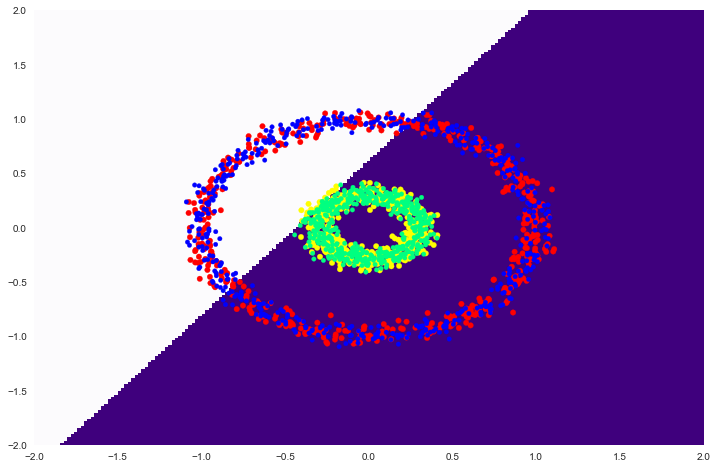

0.69899999999999995

In [329]:
evaluateNetwork(normalModel, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

<p style="text-align:center;font-size:95%"><b>Figura 1:</b> Clasificación lograda por un solo perceptrón del conjunto de datos generado sin ruido</p>

La barrera de clasificación se observa en la división de colores del fondo del gráfico. La barrera es una línea recta que intenta cubrir a todos los datos del círculo interior, con problemas para clasificar los del círculo exterior.

Los colores cálidos (rojo y amarillo) corresponden a los datos de entrenamiento, y los fríos (azul y verde) a los datos de prueba.

1000/1000 [==============================] - 0s 68us/step
Accuracy: 0.636000                                          


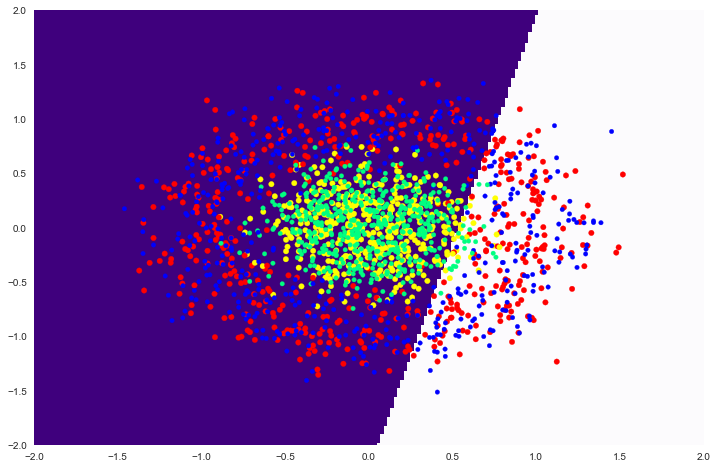

0.63600000000000001

In [330]:
evaluateNetwork(noisyModel, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

<p style="text-align:center;font-size:95%"><b>Figura 1:</b> Clasificación lograda por un solo perceptrón del conjunto de datos generado con ruido</p>

Se observa que con ruido pasa lo mismo, pero se genera la barrera de una forma distinta. Por lo que sabemos de redes neuronales, no debería ser posible resolver este problema sólo con una neurona. Pero, sólo por si acaso, probemos variando unos cuantos parámetros.

Con activación sigmoidal:

<p style="text-align:center;font-size:95%"><b>Figura 1:</b> Conjunto de datos inicial, formado a partir de dos circulos con ruido de 0.05.</p>

1000/1000 [==============================] - 0s 66us/step
Accuracy: 0.489000                                          


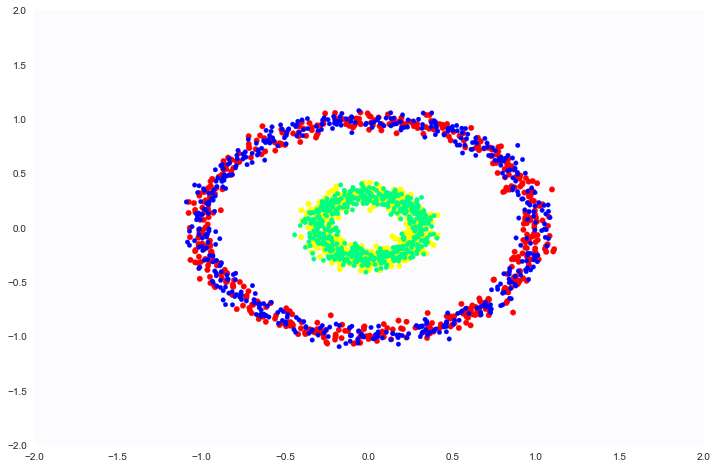

0.48899999999999999

In [331]:
testModel1 = oneLayerNetwork(X_train_normal, y_train_normal, input_activation = "sigmoid")
evaluateNetwork(testModel1, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Aparentemente la sigmoidal no es capaz de separar absolutamente nada. Es raro que el error de pruebas no sea exactamente 0.5 en todo caso...

Con activación de tangente hiperbólica:

1000/1000 [==============================] - 0s 71us/step
Accuracy: 0.648000                                          


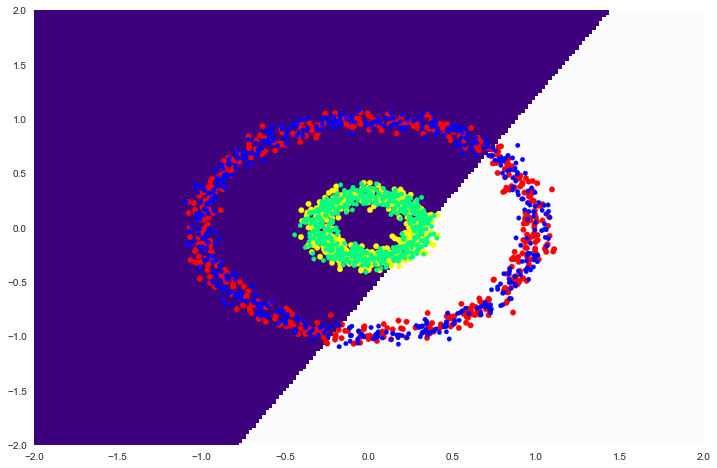

0.64800000000000002

In [333]:
testModel2 = oneLayerNetwork(X_train_normal, y_train_normal, input_activation = "tanh")
evaluateNetwork(testModel2, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Más o menos igual que antes.

Con pesos gaussianos:

1000/1000 [==============================] - 0s 82us/step
Accuracy: 0.684000                                          


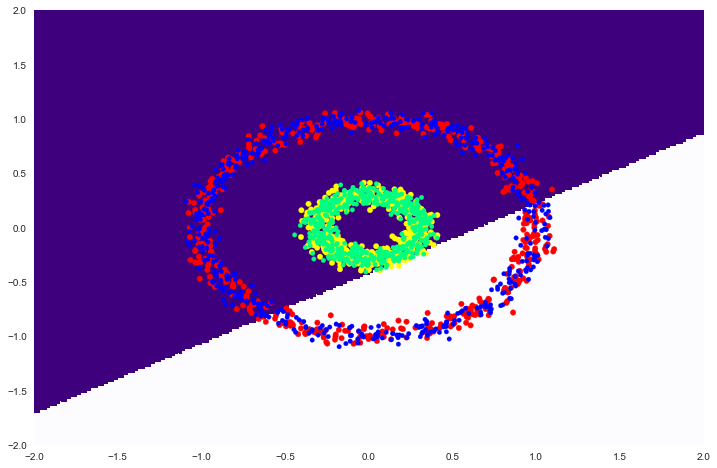

0.68400000000000005

In [335]:
testModel3 = oneLayerNetwork(X_train_normal, y_train_normal, input_init = "normal")
evaluateNetwork(testModel3, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Nótese que se define una barrera, que no se ocupa para clasificar. Nada que mirar acá.

Con error mínimo cuadrático como función de pérdida:

1000/1000 [==============================] - 0s 103us/step
Accuracy: 0.694000                                          


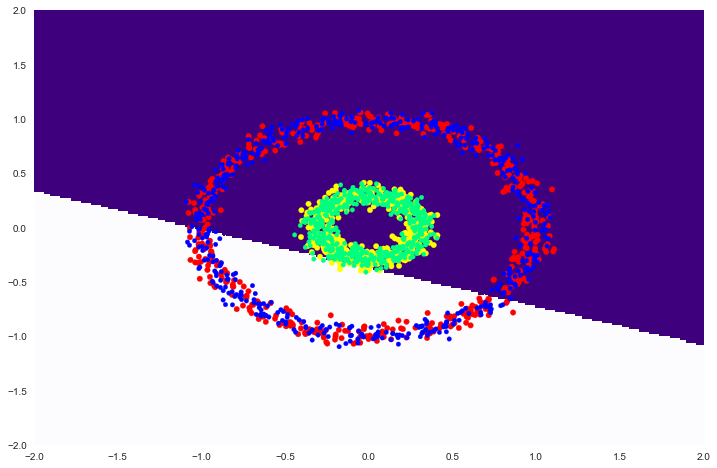

0.69399999999999995

In [336]:
testModel4 = oneLayerNetwork(X_train_normal, y_train_normal, loss = "mean_squared_error")
evaluateNetwork(testModel4, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Mejor que antes, pero no termina de convencer.

Con tangente hiperbólica, pesos gaussianos, y pérdida cuadrática media.

1000/1000 [==============================] - 0s 85us/step
Accuracy: 0.468000                                          


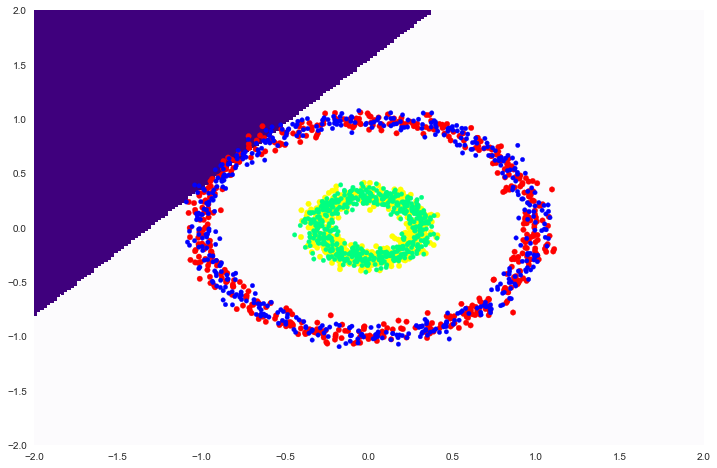

0.46800000000000003

In [338]:
testModel5 = oneLayerNetwork(X_train_normal, y_train_normal, input_init = "normal", input_activation = "tanh", loss = "mean_squared_error")
evaluateNetwork(testModel5, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Notar que aquí el clasificador prefirió invertir la clasificación. Ese 0.332 de precisión es lo mismo que un 0.668 si se mira al revés.

Ahora sí podemos llegar a la conclusión de que una sóla neurona no basta.

Empleemos ahora varias neuronas con una capa escondida, y observemos lo que sucede. Para esto emplearemos los parámetros base entregados: inicialización uniforme, activación RELU, y pérdida *cross-entropy*.

1000/1000 [==============================] - 0s 101us/step
Accuracy: 0.867000                                          


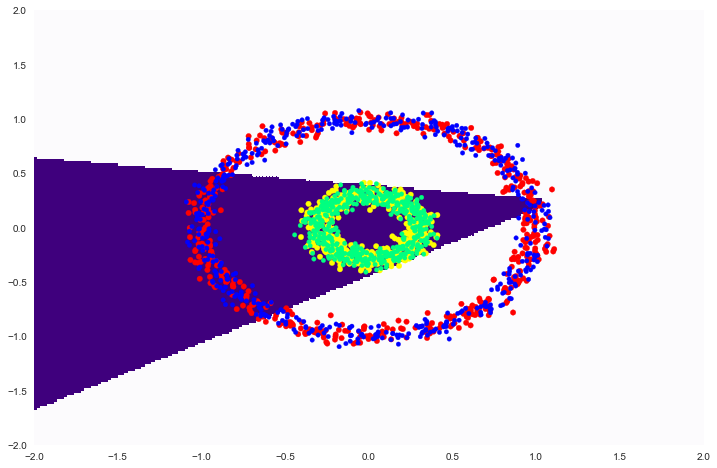

0.86699999999999999

In [340]:
twoNeuronNetwork = oneLayerNetwork(X_train_normal, y_train_normal, neurons = 2)
evaluateNetwork(twoNeuronNetwork, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observa una mejora considerable en la precisión de clasificación. La segunda neurona permite agregar un corte adicional al plano, acotando de mejor manera la clase interior.

La versión con dispersión adicional también exhibe una mejora sustancial, menor que la anterior sólo porque el ruido es una limitante fuerte.

1000/1000 [==============================] - 0s 114us/step
Accuracy: 1.000000                                          


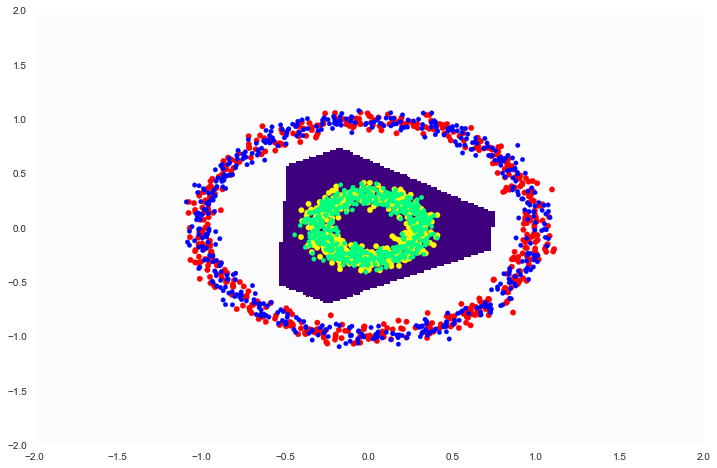

1.0

In [342]:
threeNeuronNetwork = oneLayerNetwork(X_train_normal, y_train_normal, neurons = 3)
evaluateNetwork(threeNeuronNetwork, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Con 3 neuronas ya podemos obtener una clasificación perfecta en el modelo normal.

1000/1000 [==============================] - 0s 117us/step
Accuracy: 0.947000                                          


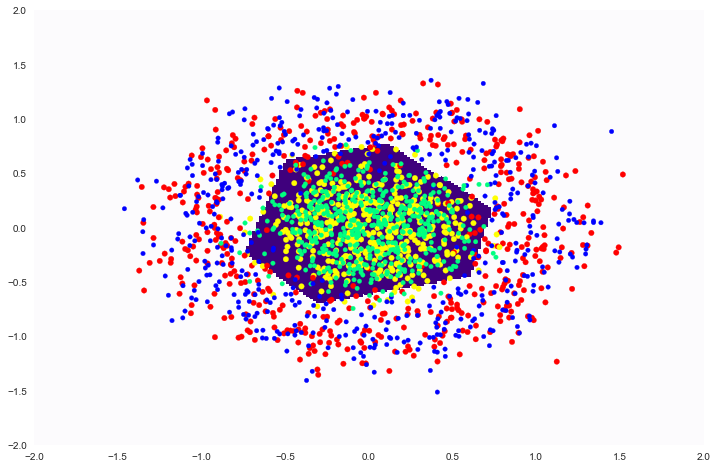

0.94699999999999995

In [344]:
threeNeuronNetwork_noisy = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = 3)
evaluateNetwork(threeNeuronNetwork_noisy, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Mientras tanto, el modelo con ruido presenta una precisión digna de un buen modelo real.

Podemos automatizar las pruebas para varias cantidades de neuronas. Como la clasificación con 3 neuronas ya llegó a precisión 1.0, aquí es donde el modelo con ruido adicional resultará ser útil.

In [346]:
neurons = [2**x for x in range(6)]
normalScore = []
noisyScore = []
for amount in neurons:
    model = oneLayerNetwork(X_train_normal, y_train_normal, neurons = amount)
    score = evaluateNetwork(model, X_train_normal, y_train_normal, X_test_normal, y_test_normal, show_results = False)
    normalScore.append(score)
    model = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = amount)
    score = evaluateNetwork(model, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, show_results = False)
    noisyScore.append(score)

1000/1000 [==============================] - 0s 194us/step


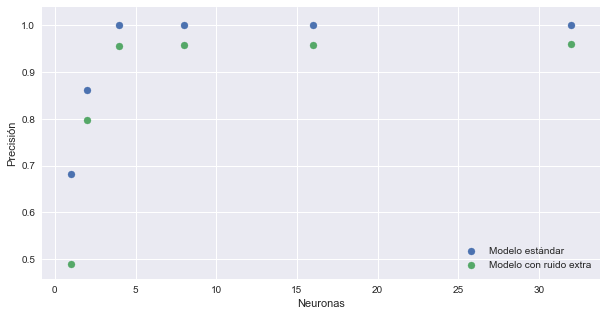

In [351]:
plt.figure(figsize = (10,5))
plt.scatter(neurons, normalScore, label = "Modelo estándar")
plt.scatter(neurons, noisyScore, label = "Modelo con ruido extra")
plt.axis("tight")
plt.xlabel("Neuronas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

Aparentemente el modelo con ruido no es capaz de predecir perfectamente, sin importar la cantidad de neuronas. Esto tiene bastante sentido, pues esa era la idea del ruido en primer lugar. Estar por sobre de 0.9 en precisión ya es bueno de todas formas.

1000/1000 [==============================] - 0s 227us/step
Accuracy: 0.956000                                          


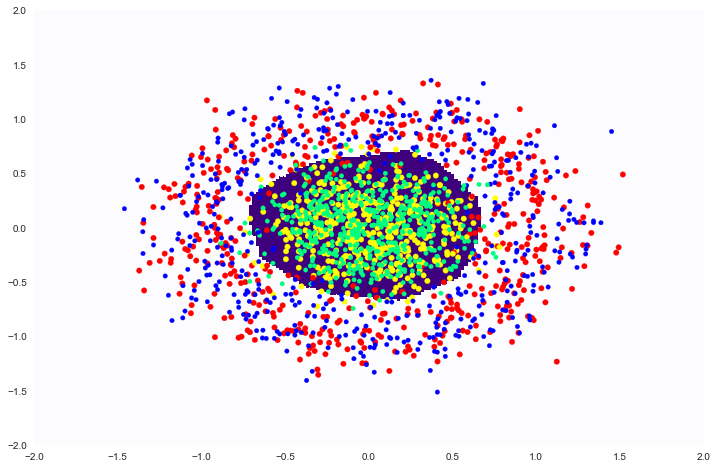

0.95599999999999996

In [352]:
displayNetwork = oneLayerNetwork(X_train_noisy, y_train_noisy, neurons = 16)
evaluateNetwork(displayNetwork, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> III) Usando árboles para resolver el problema</h3></i>

Ahora emplearemos árboles para observar la relación entre niveles del árbol y capacidad de resolver este problema. Partiremos por definir las funciones de entrenamiento y evaluación.

In [355]:
def trainTree(X_train, y_train, depth = 1, criterion = "gini", splitter = "best"):
    model = DecisionTreeClassifier(criterion = criterion, splitter = splitter, max_depth = depth, random_state = seed)
    model.fit(X_train, y_train)
    return model

def evaluateTree(tree, X_train, y_train, X_test, y_test, show_results = True):
    score = tree.score(X_test, y_test)
    if show_results:
        print("Accuracy: %f" % score)
        plot_classifier(tree, X_train, y_train, X_test, y_test, "tree")
    return score

Primero probemos lo que sucede al emplear los parámetros entregados por defecto.

Accuracy: 0.676000


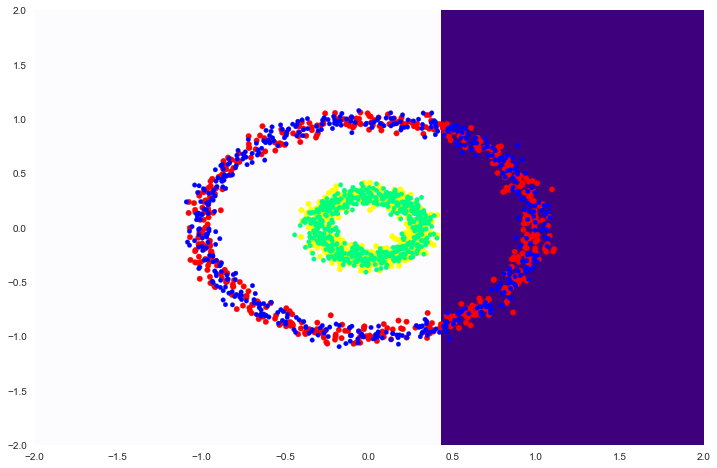

0.67600000000000005

In [356]:
testTree1 = trainTree(X_train_normal, y_train_normal)
evaluateTree(testTree1, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observa una barrera de clasificación lineal, correspondiente a un número cerca de 0.4. Esto se puede interpretar fácilmente como que el árbol está haciendo la pregunta "es el valor X menor a cierto parámetro?", indicando que su primera decisión se basa en la variable X.

Probemos qué pasa con los datos con ruido.

Accuracy: 0.632000


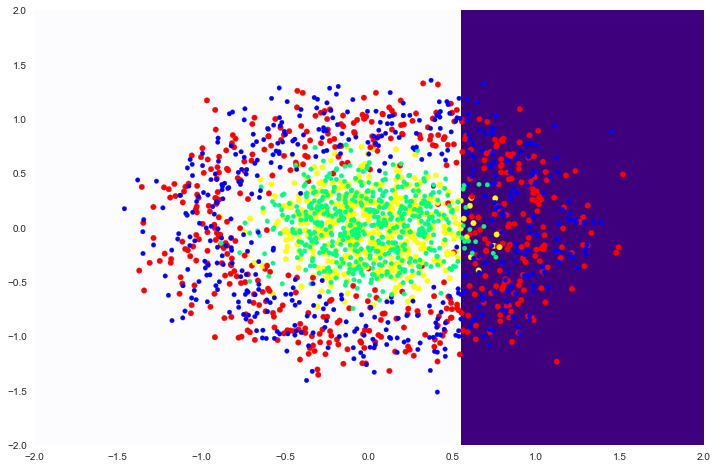

0.63200000000000001

In [357]:
testTree2 = trainTree(X_train_noisy, y_train_noisy)
evaluateTree(testTree2, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Exactamente la misma situación, variando un poco el parámetro y con una precisión ligeramente menor.

Qué sucederá con otras configuraciones para el árbol?

Accuracy: 0.676000


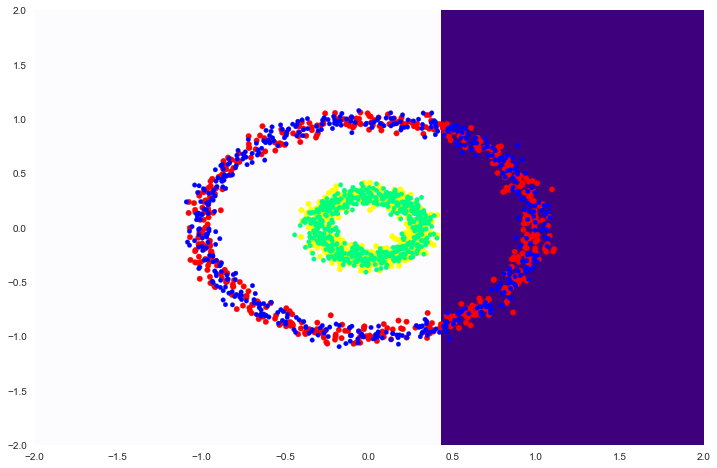

0.67600000000000005

In [359]:
testTree3 = trainTree(X_train_normal, y_train_normal, criterion = "entropy")
evaluateTree(testTree3, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Lo mismo al usar ganancia de información en vez de Gini.

Accuracy: 0.673000


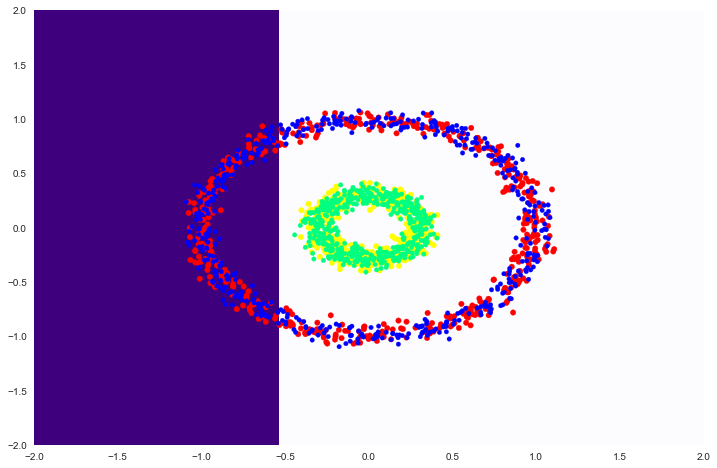

0.67300000000000004

In [360]:
testTree4 = trainTree(X_train_normal, y_train_normal, splitter = "random")
evaluateTree(testTree4, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Lo mismo al usar separación aleatoria, pero esta vez el árbol clasificó tomando el otro lado.

Accuracy: 0.673000


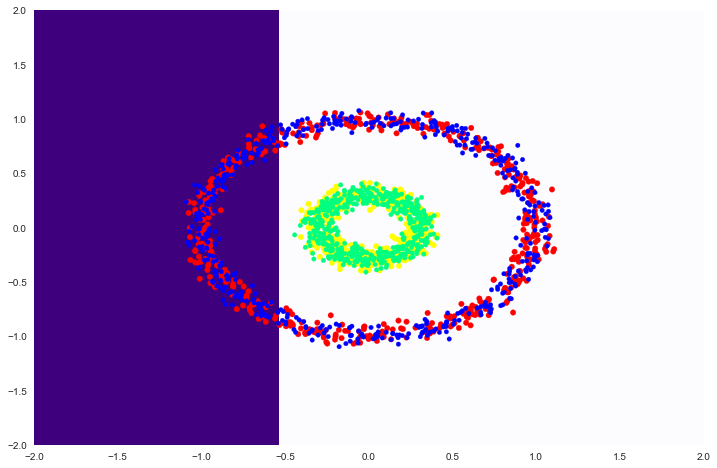

0.67300000000000004

In [361]:
testTree5 = trainTree(X_train_normal, y_train_normal, criterion = "entropy", splitter = "random")
evaluateTree(testTree5, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Y con los dos se obtiene el mismo resultado que sólamente con separación aleatoria.

Queda claro entonces que sólo con 1 nivel **no es posible realizar la separación correctamente**.

Si el árbol sigue la tendencia anterior, con dos niveles debiese mejorar sustancialmente, y con tres ya debiese clasificar perfectamente.

Accuracy: 0.863000


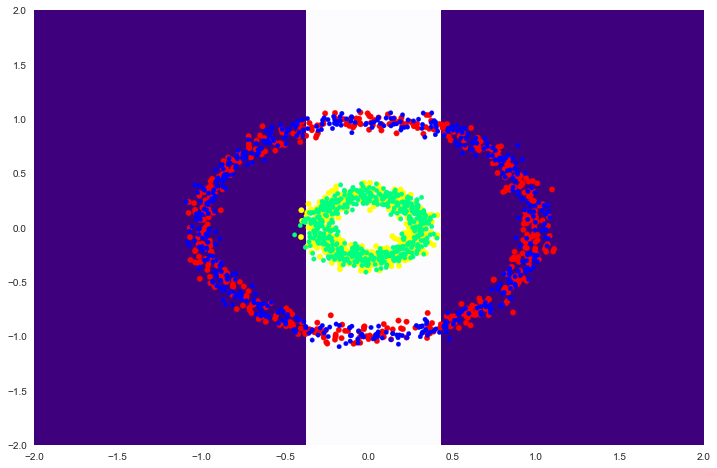

0.86299999999999999

In [362]:
testTree6 = trainTree(X_train_normal, y_train_normal, depth = 2)
evaluateTree(testTree6, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Se observan dos separaciones lineales basadas en una única variable, lo que se condice con algunos de los resultados anteriores donde se tomaba un lado de las clases o el otro. Podríamos predecir ahora que como el árbol no es capaz de manejar condiciones compuestas en términos de dos variables, entonces muy probablemente no será capaz de trazar las líneas diagonales que la red neuronal podía hacer con 3 neuronas en su primera capa. Esto implica que necesitaremos 4 niveles para hacer la clasificación en este caso.

Accuracy: 0.928000


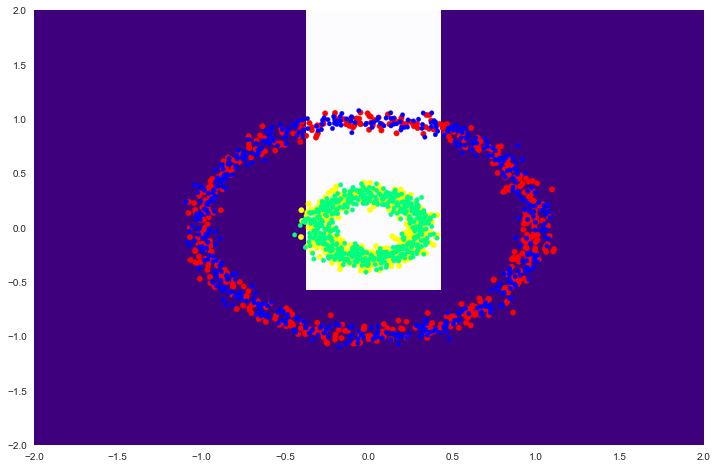

0.92800000000000005

In [364]:
testTree7 = trainTree(X_train_normal, y_train_normal, depth = 3)
evaluateTree(testTree7, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

Ya con 4 es evidente que logrará encerrar el círculo central en un cuadrado perfecto. Será más interesante revisar los datos con ruido en este caso.

Accuracy: 0.932000


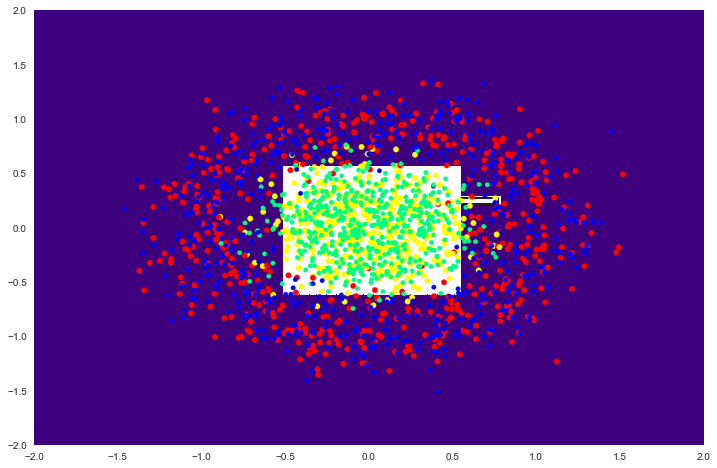

0.93200000000000005

In [365]:
testTree8 = trainTree(X_train_noisy, y_train_noisy, depth = 4)
evaluateTree(testTree8, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy)

Para los datos con ruido, se puede observar que la primera decisión que toma es probablemente la misma que hemos visto en los gráficos anteriores: preguntarse si la variable X es mayor o menor a cierto valor cerca de 0.5. En el gráfico se puede apreciar que, de tomar cierta rama del árbol, se siguen realizando preguntas que hacen aparecer una región rectangular irregular, que probablemente intenta clasificar correctamente un par de datos adicionales. Es decir, para una altura máxima de 4 niveles, el árbol ya está mostrando tendencia al *overfitting*.

Ahora comparemos lo que pasa con el número de niveles. Se puede predecir que a partir de cierta cantidad (probablemente 4), el árbol con datos normales ya predecirá de forma perfecta, mientras que el árbol con datos con ruido puede que empiece a bajar su precisión.

In [366]:
depths = range(2, 21)
normalScore = []
noisyScore = []
for amount in depths:
    model = trainTree(X_train_normal, y_train_normal, depth = amount)
    score = evaluateTree(model, X_train_normal, y_train_normal, X_test_normal, y_test_normal, show_results = False)
    normalScore.append(score)
    model = trainTree(X_train_noisy, y_train_noisy, depth = amount)
    score = evaluateTree(model, X_train_noisy, y_train_noisy, X_test_noisy, y_test_noisy, show_results = False)
    noisyScore.append(score)

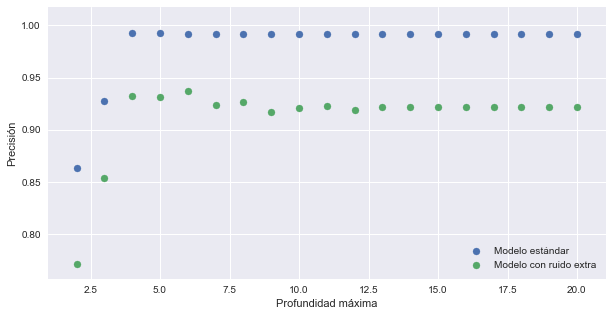

In [367]:
plt.figure(figsize = (10,5))
plt.scatter(depths, normalScore, label = "Modelo estándar")
plt.scatter(depths, noisyScore, label = "Modelo con ruido extra")
plt.axis("tight")
plt.xlabel("Profundidad máxima")
plt.ylabel("Precisión")
plt.legend()
plt.show()

Los resultados se ajustan a lo esperado. A partir de cierto punto, el modelo con ruido empieza a converger hacia cierta precisión, y se hipotetiza que probablemente se quede ahí: está clasificando perfectamente todos los datos de entrenamiento con regiones que los sobreajustan, pero está fallando en los puntos de prueba que quedan fuera de estas regiones, que serán siempre los mismos al mantenerse constantes los puntos.

La conclusión final es: **un árbol de múltiples niveles nos permite clasificar problemas linealmente inseparables**.

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> IV) Usando una transformación de espacio para linealizar el problema</h3></i>

Un enfoque distinto consiste en transformar los datos para convertirlos a un espacio donde adquieran una forma lineal. Es una de las técnicas que hemos visto previamente en el curso (las SVM y su *kernel trick*, por ejemplo). Ahora las aprovecharemos para aplicar cualquier técnica de naturaleza lineal. Transformaremos la variable X del problema para ver qué pasa.

In [370]:
normal_kpca = KernelPCA(n_components = 2,kernel = "rbf", gamma = 5, random_state = seed)
normal_kpca = normal_kpca.fit(X_train_normal)
Xkpca_train_normal = normal_kpca.transform(X_train_normal)
Xkpca_test_normal = normal_kpca.transform(X_test_normal)

noisy_kpca = KernelPCA(n_components = 2,kernel = "rbf", gamma = 5, random_state = seed)
noisy_kpca = noisy_kpca.fit(X_train_noisy)
Xkpca_train_noisy = noisy_kpca.transform(X_train_noisy)
Xkpca_test_noisy = noisy_kpca.transform(X_test_noisy)

Ahora necesitamos un algoritmo que pueda resolver problemas mediante fronteras lineales. Las redes neuronales de 1 sóla neurona que empleamos con anterioridad sirven, puesto que ya tenemos todo listo e implementado para usarlas.

1000/1000 [==============================] - 0s 244us/step
Accuracy: 1.000000                                          


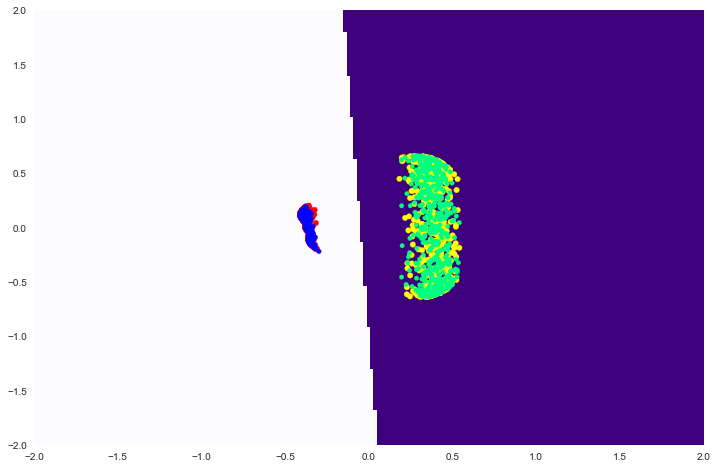

1.0

In [371]:
normal_model_kpca = oneLayerNetwork(Xkpca_train_normal, y_train_normal)
evaluateNetwork(normal_model_kpca, Xkpca_train_normal, y_train_normal, Xkpca_test_normal, y_test_normal)

La frontera simple de la red de una sóla neurona permite obtener una precisión del 100% en los datos de prueba en la región transformada.

1000/1000 [==============================] - 0s 306us/step
Accuracy: 0.958000                                          


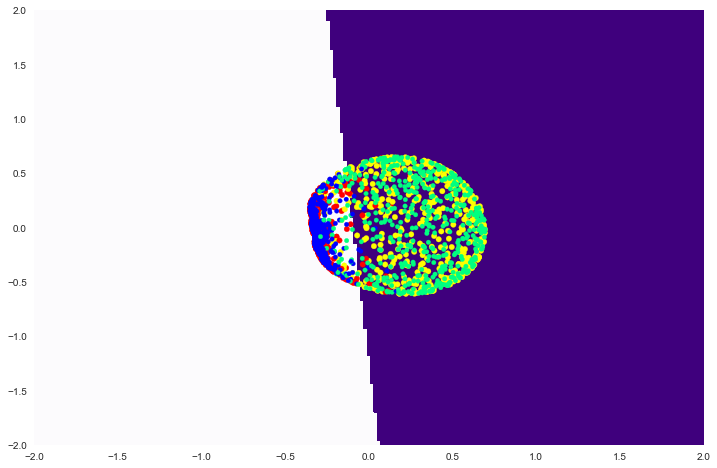

0.95799999999999996

In [372]:
noisy_model_kpca = oneLayerNetwork(Xkpca_train_noisy, y_train_noisy)
evaluateNetwork(noisy_model_kpca, Xkpca_train_noisy, y_train_noisy, Xkpca_test_noisy, y_test_noisy)

Esta clasificación ya es mejor que la de 3 neuronas para los mismos datos. Es más, es mejor que la de 16 neuronas vista anteriormente, y probablemente mejor que la de N neuronas para el mismo problema. También se comporta mejor que un árbol con muchos niveles. Destaca la forma "circular" que toman los datos después de transformar la componente X, se hipotetiza que esto se debe a la dispersión de los datos (que es de naturaleza gaussiana) y la transformación del kernel (que también es gaussiana).

Curiosamente, agregarle neuronas a la red empeora ligeramente las predicciones.

1000/1000 [==============================] - 0s 240us/step
Accuracy: 0.953000                                          


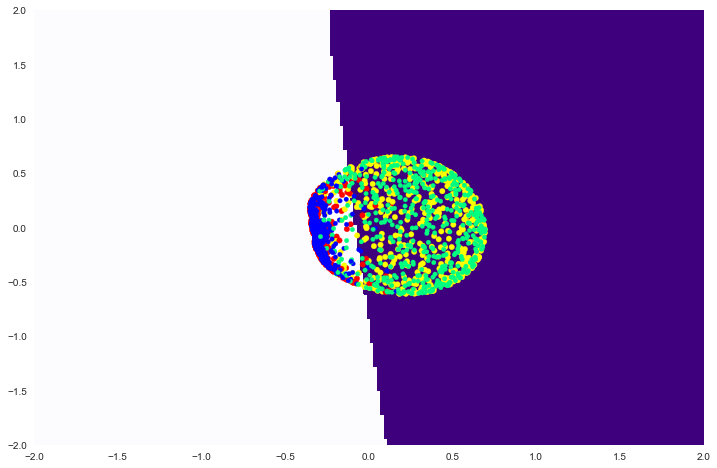

0.95299999999999996

In [374]:
noisy_model_kpca_2 = oneLayerNetwork(Xkpca_train_noisy, y_train_noisy, neurons = 32)
evaluateNetwork(noisy_model_kpca_2, Xkpca_train_noisy, y_train_noisy, Xkpca_test_noisy, y_test_noisy)

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80">Para atacar exitosamente problemas de naturaleza no lineal, es extremadamente importante tener un buen conocimiento de las técnicas a disposición y las formas en las que pueden mejorarse y combinarse, así como las formas en las que NO deberían combinarse.</h2></i>




<i><h2 style="font-family:serif;font-size:260%; text-align:center;color:#004d80"> Calidad de un Vino</h2></i>

Para esta sección utilizaremos los atributos fisicoquimicos de una serie de muestras de vino, utilizaremos técnicas de regresión y clasificación para perfilar las distintas sepas y predecir la calidad de una muestra.

In [5]:
# a) generamos el el dataframe con el que trabajaremos
df_red = pd.read_csv("data/winequality-red.csv", sep = ";")
df_white = pd.read_csv("data/winequality-white.csv", sep = ";")
df  = pd.concat([df_red,df_white], axis = 0)


In [6]:
r = pd.DataFrame(['red']*len(df_red), columns=['tipo'])
w = pd.DataFrame(['white']*len(df_white), columns=['tipo'])
a = pd.concat([r,w], axis = 0)
lb = preprocessing.LabelBinarizer()
a = pd.DataFrame(lb.fit_transform(a), columns=['tipo'])
df.reset_index(inplace=True, drop=True)
df = pd.concat([df,a], axis = 1)
df_bin = copy.copy(df)
df_bin.head()
#PD: Para el disgusto del ayudante de estadística, estos valores deben ser codificados de forma binaria, al igual que
#el tipo de vino, ya que sklearn solo acepta valores numericos por el momento, para hacer clasificación y regresión
df_bin['binary quality'] = [1 if q>5 else 0 for q in df.quality]
#df_bin['binary quality'] = ['bueno' if q>5 else 'malo' for q in df.quality]

Realizaremos primero un análisis descriptivo y exploratorio, seguido de un breve proceso de selección de atributos.

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> I) Análisis Descriptivo y Exploratorio</h3></i>

In [7]:
df_bin.describe().round(2)

fixed acidity  volatile acidity  citric acid  residual sugar  \
count        6497.00           6497.00      6497.00         6497.00   
mean            7.22              0.34         0.32            5.44   
std             1.30              0.16         0.15            4.76   
min             3.80              0.08         0.00            0.60   
25%             6.40              0.23         0.25            1.80   
50%             7.00              0.29         0.31            3.00   
75%             7.70              0.40         0.39            8.10   
max            15.90              1.58         1.66           65.80   

       chlorides  free sulfur dioxide  total sulfur dioxide  density       pH  \
count    6497.00              6497.00               6497.00  6497.00  6497.00   
mean        0.06                30.53                115.74     0.99     3.22   
std         0.04                17.75                 56.52     0.00     0.16   
min         0.01                 1.00                  6.00     0.99     2.72   
25%         0.04                17.00                 77.00     0.99     3.11   
50%         0.05                29.00                118.00     0.99     3.21   
75%         0.06                41.00                156.00     1.00     3.32   
max         0.61               289.00                440.00     1.04     4.01   

       sulphates  alcohol  quality     tipo  binary quality  
count    6497.00  6497.00  6497.00  6497.00         6497.00  
mean        0.53    10.49     5.82     0.75            0.63  
std         0.15     1.19     0.87     0.43            0.48  
min         0.22     8.00     3.00     0.00            0.00  
25%         0.43     9.50     5.00     1.00            0.00  
50%         0.51    10.30     6.00     1.00            1.00  
75%         0.60    11.30     6.00     1.00            1.00  
max         2.00    14.90     9.00     1.00            1.00

> * La variable *residual sugar* muestra una considerable diferencia entre su tercer cuartil y su máxima, probablemente haya una marca de vinos que posee un alto contenido de este químico. Para esta misma variable se observa una desviación estándar relativamente alta en comparación con la media, su distribución probablemente sea achatada.
> * La calidad media de las muestas de vino es de 5.82, lo que como veremos más adelante, corresponde a una muestra en la que la calidad de los vinos es buena en general.
> * La cantidad de alcohol que poseen los vinos muestreados es bastante similar, siendo una media de 10.49 con una baja disviación estándar de 1.19, en un rango de 8.00 a 14.90.
> * La variable *free sulfur dioxide*, al igual que la variable *residual sugar* posee una diferencia entre su cuartíl tres y su máxima bastante grande, nuevamente puede ser indicio de una marca de vino que utilice grandes cantidades de este químico para la elaboración de sus productos.

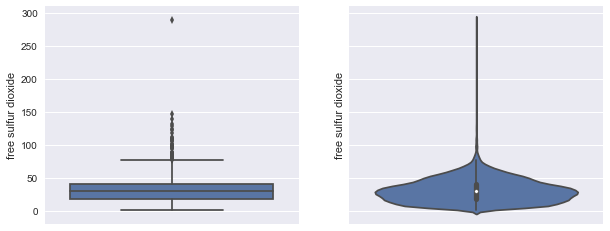

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4));
#ax1 = fig.add_subplot(121);
#ax2 = fig.add_subplot(122,sharey = ax1);
#ax = sn.swarmplot(data=df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']]);
#sn.boxplot(data = df['free sulfur dioxide'], orient = 'v');
sn.violinplot(df['free sulfur dioxide'],ax = ax2, orient = 'v');
sn.boxplot(df['free sulfur dioxide'], orient='v', ax = ax1);

<p style="text-align:center;font-size:95%"><b>Figura 2.1:</b> Graficos de violín y boxplot para la variable 'free sulfur dioxide'</p>

In [9]:
df[np.abs(df['free sulfur dioxide']-df['free sulfur dioxide'].mean())>=250]

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
6344            6.1              0.26         0.25             2.9      0.047   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
6344                289.0                 440.0  0.99314  3.44       0.64   

      alcohol  quality  tipo  
6344     10.5        3     1

Parece haber solo un outlier que aleja notablemente del grueso de la distribución para la variable *free sulfur dioxide*, la calidad de dicho vino es baja y su tipo es 'blanco'. Este outlier puede interferir en el poder predictivo de un modelo si este se basa en alguna métrica de distancia, puede ser tratado y reemplazado el valor de dicho registro por el de la mediana de la distribución de la variable en cuestión, o puede ser dejado intacto con el argumento de que justamente este tipo de irragularidades pueden enseñarle a una máquina a detectar que valores atípicos generan un vino de mala calidad. Por ahora se dejará asi y se experimentará luego para determinar si hay cambios significativos en el poder de generalización del modelo.

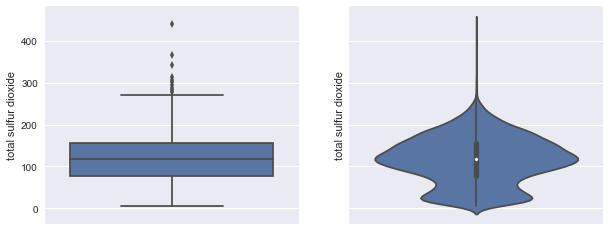

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4));
#ax1 = fig.add_subplot(121);
#ax2 = fig.add_subplot(122,sharey = ax1);
#ax = sn.swarmplot(data=df_unicard[['SALDO_DISPONIBLE','CUPO_NACIONAL']]);
#sn.boxplot(data = df['free sulfur dioxide'], orient = 'v');
sn.violinplot(df['total sulfur dioxide'],ax = ax2, orient = 'v');
sn.boxplot(df['total sulfur dioxide'], orient='v', ax = ax1);

Un comportamiento similar se observa para la variable 'total sulfur dioxide', relacionada aparentemente con 'free sulfur dioxide', sin embargo, la distribución no se ve estropeada por tan solo un valor extremadamente alto, sino que hay una serie de registros que presentan valores altos de esta variable, por lo que el máximo en este caso no se considerará como un outlier que deba ser cuestionado.

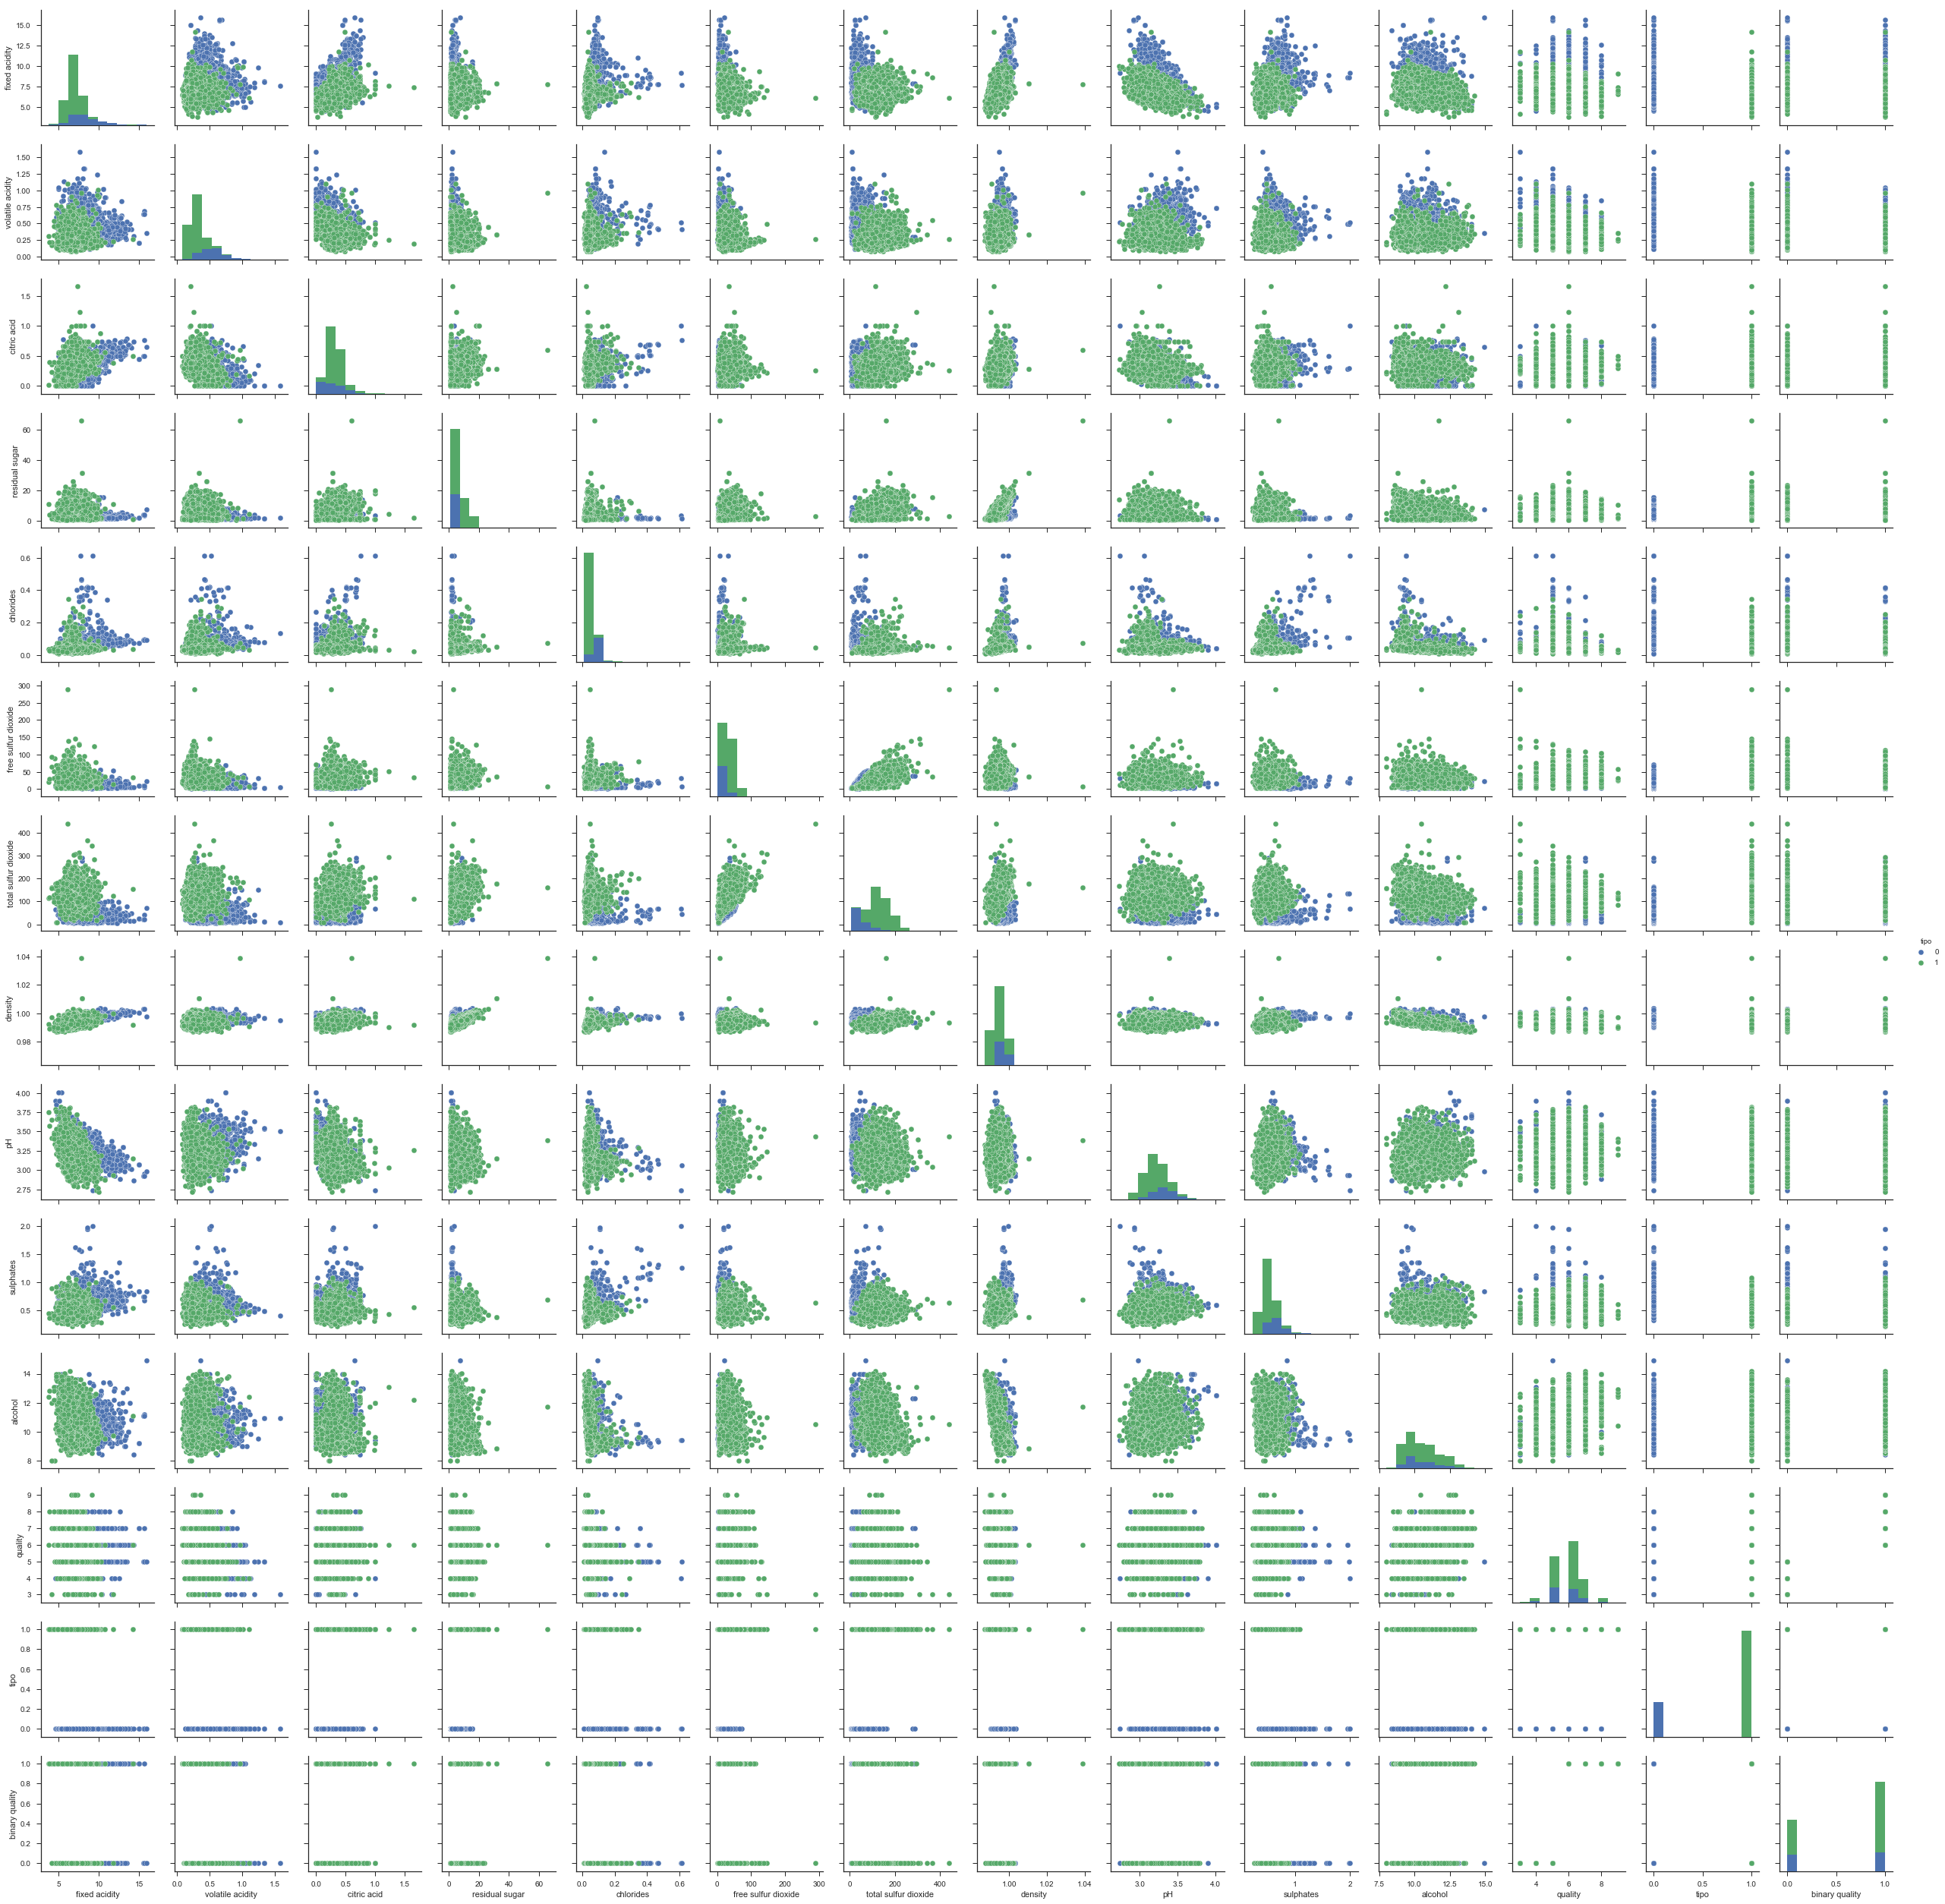

In [11]:
sn.set(style="ticks")

sn.pairplot(df_bin, hue="tipo");

La anterior matriz de gráficos de dispersión muestra algunas relaciones interesantes que hacen dudar sobre replicación de información, como por ejemplo la relación entre 'total sulfur dioxide' y 'free sulfur dioxide', en este caso puede ser que en efecto la información de una de estas variables esté de forma implícita en la otra.<br>
* Se observan relaciones interesantes como la de las variables *density* y *residual sugar*.
* Parece ser que graficar la variable 'chlorides' con *fixed acidity*, *volatile acidity* o *citric acid* permite obtener una división relativamente clara de el tipo de vino, lo que probablemente sea consecuencia de las diferencias en la composición y propiedades químicas propias de cada tipo de vino.

Estudiemos las correlaciones para verficar si hay información replicada:

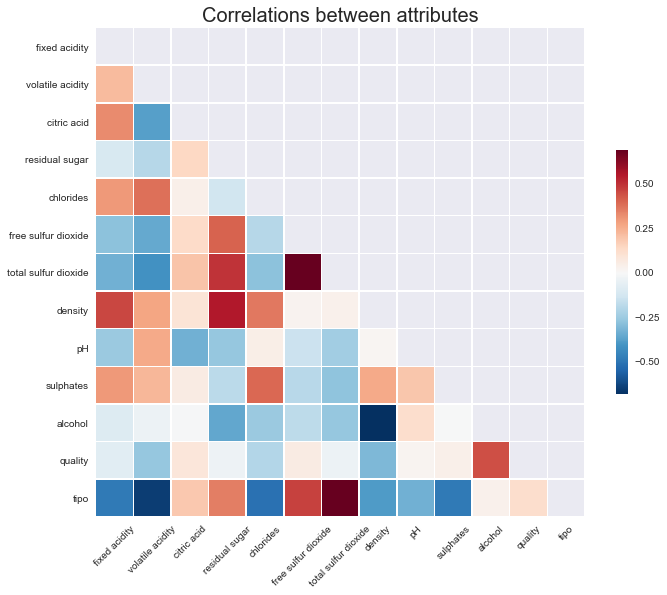

In [382]:
#pd.corr(df['free sulfur dioxide'], df['total sulfur dioxide'])
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
plt.title("Correlations between attributes", fontsize = 20)
sn.heatmap(df.corr(),mask = mask, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws={"shrink":.5});
plt.xticks(rotation = 45);

Destaca la correlación que hay entre *free sulfur dioxide* y *total sulfur dioxide*, con el fin de tener claridad sobre una posible transformación subyacente que implica replicación de información, realizaremos una regresión lineal entre ambos atributos, con un nivel de confianza de 95% para rechazar la hipótesis de que *free sulfur dioxide* no condiciona los valores de *total sulfur dioxide*.

In [13]:
x_sm = df_bin['free sulfur dioxide']
#x_sm = sm.add_constant(x_sm)
#x_sm.insert(x_sm.shape[1], 'intercept', np.ones(x_sm.shape[0]))
y_sm = df_bin['total sulfur dioxide']

model = sm.OLS(y_sm,x_sm)
results = model.fit()
print(results.summary())

#linreg = lm.LinearRegression(fit_intercept = False)
#linreg.fit(df_bin['free sulfur dioxide'], df_bin['total sulfur dioxide'])

                             OLS Regression Results                             
Dep. Variable:     total sulfur dioxide   R-squared:                       0.876
Model:                              OLS   Adj. R-squared:                  0.876
Method:                   Least Squares   F-statistic:                 4.580e+04
Date:                  Sat, 23 Dec 2017   Prob (F-statistic):               0.00
Time:                          22:26:44   Log-Likelihood:                -34008.
No. Observations:                  6497   AIC:                         6.802e+04
Df Residuals:                      6496   BIC:                         6.802e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
free sulfur di

El p-valor que entrega el modelo para el coeficiente de la regresión es menor a 0.05, por lo que vamos a aceptar la hipótesis de que existe una transformación lineal que explica 'total sulfur dioxide' a través de 'free sulfur dioxide' con un 95% de confianza, eliminaremos entonces del modelo el segundo atributo.

In [90]:
df_bin.drop(['free sulfur dioxide'], axis = 1, inplace = True);

Como ya sabemos que el atributo *quality* particiona perfectamente el problema, eliminaremos esta variable para que el árbol no le otorgue demasiada importancia a este atributo con respecto a los demás, en lugar de esto, trataremos el problema como si fuese un problema de clasificación binaria, donde fijaremos un umbral de calidad de 5 o más para un vino de buena calidad y su complemento para uno de mala calidad, generamos una etiqueta artifical y entrenamos a distintos clasificadores para observar su desempeño:

In [91]:
df_bin.drop(['quality'], axis = 1, inplace = True)
x_train, x_test, y_train, y_test = train_test_split(
    df_bin.loc[:, df_bin.columns != 'binary quality'],
    df_bin.loc[:, df_bin.columns == 'binary quality'],
    test_size = 0.25,
    shuffle=True,
    random_state = 42)

<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> II) Árbol de Clasificación Binario</h3></i>

Nuestra primera aproximación para modelar el problema será mediante la utilización de un árbol de clasificación multinivel, la matriz de entrenamiento y test es de la siguiente forma:

In [93]:
#c) CT multinivel, evaluación de metrica F1
print("Nº Atributos: %d" %x_train.shape[1])
print("Nº Obs. de entrenamiento: %d" %x_train.shape[0])
print("Nº Obs. de test: %d" %x_test.shape[0])

Nº Atributos: 11
Nº Obs. de entrenamiento: 4872
Nº Obs. de test: 1625


In [106]:
#Primero veamos a que resultado llega restringiendo la profundidad a 5
mean_tree_f1error, tree_clf = cv_error(x_train, y_train, method = 'TreeClassifier', k = 10, max_depth = 5)

Para obtener un modelo, debemos ajustar sus hiperparámetros, en el caso de nuestro árbol de clasificación debemos encontrar la profundidad máxima permitida al árbol que maximice la métrica que estamos utilizando para medir el rendimiento del mismo, en nuestro caso el *F1 Score*. Utilizando *10-Fold Cross-Validation* obtenemos el siguiente gráfico:

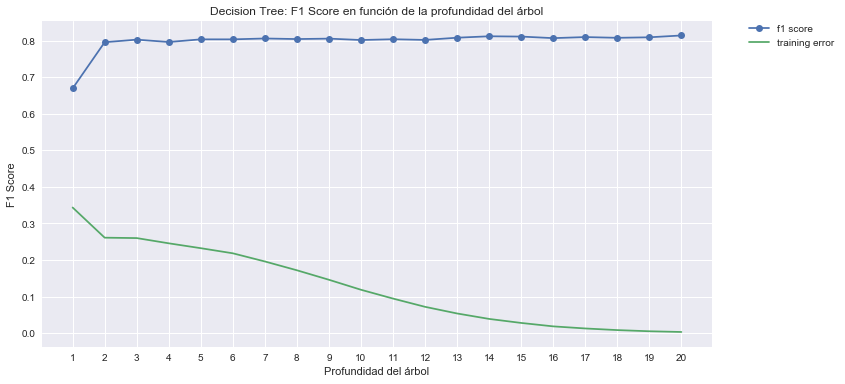

In [384]:
best_tree,best_tree_score = plot_cv_error(x_train, y_train, meth = 'TreeClassifier',max_depth = 20)

Observamos un claro sobreajuste después de fijar una profundidad máxima de catorce o quince niveles, la profundidad máxima del árbol que obtuvo la mejor métrica de *F1 Score* es el siguiente:

In [385]:
print("Best Validation tree depth: %d" % best_tree.max_depth)
print("Best Validation F1 Score: %.2f" % best_tree_score)

Best Validation tree depth: 20
Best Validation F1 Score: 0.81


El correspondiente error y *F1 score* de pruebas es:

In [231]:
print("Test error for best tree:%.2f" %best_tree.score(x_test,y_test))
print("Test F1 score for best tree:%.2f" %f1_score(y_test,best_tree.predict(x_test)))

Test error for best tree:0.75
Test F1 score for best tree:0.80


El ranking de importancia de los atributos creado por el clasificador es el siguiente:

In [244]:
#len(x_train.columns)
#len(best_tree.feature_importances_)

pd.DataFrame(best_tree.feature_importances_.round(3), index=x_train.columns, columns = ['Importance Score']).sort_values(by = 'Importance Score', ascending = False)

Importance Score
alcohol                          0.230
volatile acidity                 0.159
residual sugar                   0.090
citric acid                      0.081
sulphates                        0.080
density                          0.078
fixed acidity                    0.075
pH                               0.073
chlorides                        0.070
total sulfur dioxide             0.063
tipo                             0.001

Cabe destacar que no hay un sesgo en la calidad de los vinos, es decir, los vinos de la muestra que son de un tipo, no presentan una calidad superior en promedio a los del otro tipo.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80">El azucar y el nivel de alcohol juegan un papel importante a la hora de determinar la calidad de un vino, al igual que la acidez volátil del mismo.</h2></i>



<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> III) Bosque Aleatorio</h3></i>

Ahora procederemos a abordar el problema mediante el método de ensamblado de bosque aleatorio.

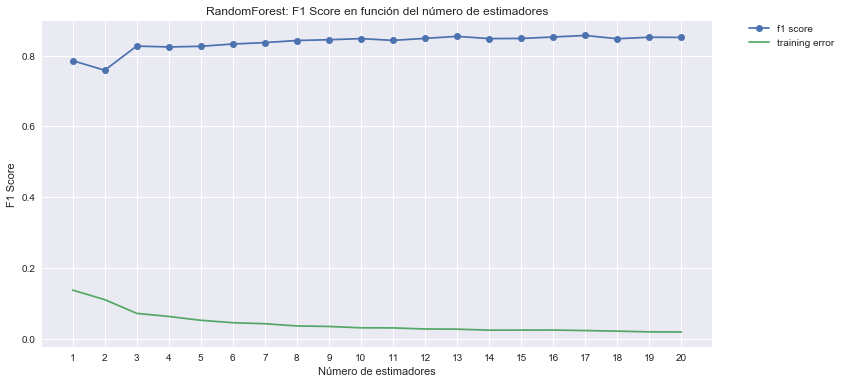

In [290]:
best_forest,best_forest_score = plot_cv_error(x_train, y_train, meth = 'RandomForest',
                                       max_depth = best_tree.max_depth, max_estimators = 20)

Los parámetros del mejor bosque aleatorio, según nuestra métrica de *F1 Score* son:

In [268]:
print("Best Validation Forest tree depth: %d" % best_forest.max_depth)
print("Best Validation Forest number of estimators: %d" % best_forest.n_estimators)
print("Best Validation F1 Score: %.2f" % best_forest_score)

Best Validation Forest tree depth: 14
Best Validation Forest number of estimators: 17
Best Validation F1 Score: 0.86


El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [271]:
print("Test error for best forest:%.2f" %best_forest.score(x_test,y_test))
print("Test F1 score for best forest:%.2f" %f1_score(y_test,best_forest.predict(x_test)))

Test error for best forest:0.80
Test F1 score for best forest:0.85


Obtuvimos una leve mejora de 0.05 en la métrica utilizando el método de RandomForest en comparación con el árbol de clasificación binario.

In [272]:
pd.DataFrame(best_forest.feature_importances_.round(3), index=x_train.columns,
             columns = ['Importance Score']).sort_values(by = 'Importance Score', ascending = False)

Importance Score
alcohol                          0.155
volatile acidity                 0.126
density                          0.125
total sulfur dioxide             0.097
residual sugar                   0.088
chlorides                        0.088
sulphates                        0.087
citric acid                      0.084
pH                               0.077
fixed acidity                    0.071
tipo                             0.003

Nuestro método de ensamblado encuentra que los atributos más relevantes son el alcohol, la acidez volátil y la densidad, en este caso el azucar residual no parece jugar un papel especialmente importante a la hora de determinar la calidad de un vino.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80"> El bosque aleatorio deduce que los atributos más relevantes en la calidad de un vino son el nivel de alcohol que posee, su acidez volátil y la densidad.</h2></i>



<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> IV) AdaBoost</h3></i>

En esta sección trabajaremos utilizando el método de ensamblado Adaboost.

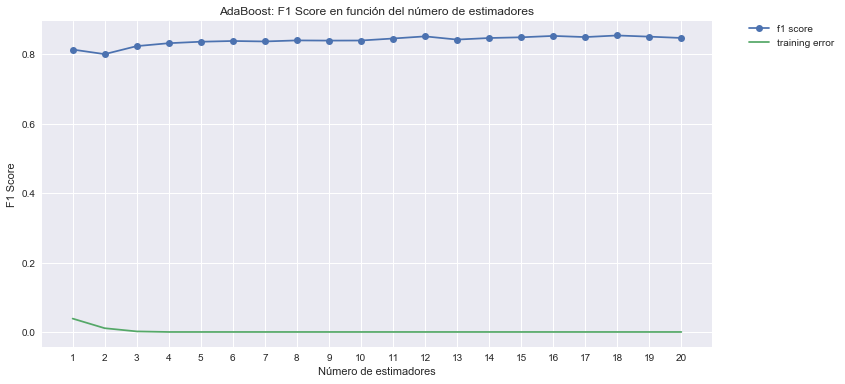

In [281]:
best_ada,best_ada_score = plot_cv_error(x_train, y_train, meth = 'AdaBoost',
                                       max_depth = best_tree.max_depth, max_estimators = 20)

AdaBoost al parecer se sobreajusta considerablemente rápido en comparación con el bosque aleatorio, vemos que para tan solo un número de estimadores de 3 ya se reduce el error de entrenamiento a 0.0.

Los parámetros del mejor AdaBoost, según nuestra métrica de *F1 Score* son:

In [283]:
print("Best Validation AdaBoost number of estimators: %d" % best_ada.n_estimators)
print("Best Validation F1 Score: %.2f" % best_ada_score)

Best Validation AdaBoost number of estimators: 18
Best Validation F1 Score: 0.85


El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [285]:
print("Test error for best AdaBoost:%.2f" %best_ada.score(x_test,y_test))
print("Test F1 score for best AdaBoost:%.2f" %f1_score(y_test,best_ada.predict(x_test)))

Test error for best AdaBoost:0.79
Test F1 score for best AdaBoost:0.84


<i><h3 style="font-family:serif;font-size:200%; text-align:left;color:#4d4d4d"> V) K Nearest Neighbors Classifier</h3></i>

Finalmente, utilizaremos el clasficador K-Nearest Neightbors para poder contrastar con un método de aprendizaje no supervisado.

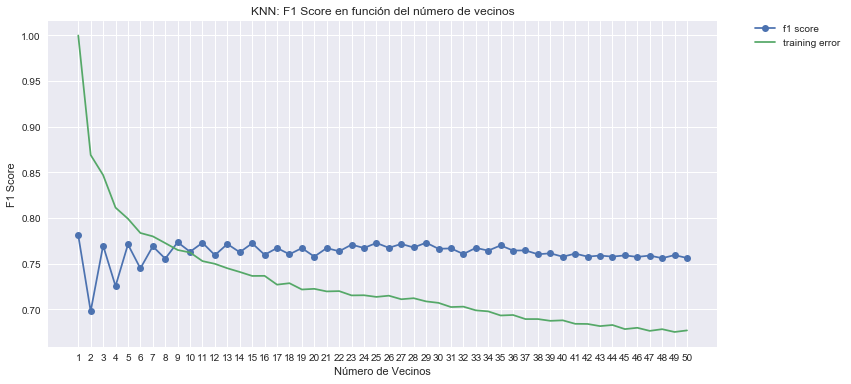

In [297]:
best_knn,best_knn_score = plot_cv_error(x_train, y_train, meth = 'KNN', max_neighbors = 50)

Curiosamente los máximos locales en la curva de *F1 Score* se parecen producir siempre para un número impar de vecinos. El error de entrenamiento parece bajar monótonamente a mayor número de vecinos, probablemente sea, debido a la naturaleza del algoritmo, sobreajuste al conjunto de entrenamiento. En la gráfica el *peak* de la métrica se obtiene para el primer valor probado, para tan solo un vecino.

In [299]:
print("Best Validation KNN number of neighbors: %d" % best_knn.n_neighbors)
print("Best Validation F1 Score: %.2f" % best_knn_score)

Best Validation KNN number of neighbors: 1
Best Validation F1 Score: 0.78


No hemos logrado superar la métrica para el conjunto de validación que teníamos hasta el momento. El correspondiente error y métrica *F1 Score* para el conjunto de pruebas es:

In [300]:
print("Test error for best KNN:%.2f" %best_knn.score(x_test,y_test))
print("Test F1 score for best KNN:%.2f" %f1_score(y_test,best_knn.predict(x_test)))

Test error for best KNN:0.72
Test F1 score for best KNN:0.77


Tampoco hemos logrado superar la métrica para el conjunto de pruebas.

In [310]:
pd.DataFrame([f1_score(y_test,best_tree.predict(x_test)).round(2), 
              f1_score(y_test,best_forest.predict(x_test)).round(2), 
              f1_score(y_test,best_ada.predict(x_test)).round(2), 
              f1_score(y_test,best_knn.predict(x_test)).round(2)],
             index = ['Decision Tree', 'Random Forest', 'AdaBoost', 'KNN'],
             columns = ['Test F1 Score']).sort_values(by = 'Test F1 Score', ascending = False)


Test F1 Score
Random Forest           0.84
AdaBoost                0.84
Decision Tree           0.79
KNN                     0.77

El mejor *F1 Score* para el conjunto de pruebas lo obtienen los métodos de Bosque Aleatorio y AdaBoost.

<i><h2 style="font-family:serif;font-size:160%; text-align:center;color:#004d80"> El Bosque Aleatorio y AdaBoost obtienen los mejores resultados cuando se requiere predecir la calidad de un vino, obteniendo ambos una métrica *F1 Score* igual a 0.84</h2></i>

